# **Imports & Config**

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

2026-01-02 19:16:49.330722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767381409.807955      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767381409.933243      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767381411.073574      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767381411.073619      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767381411.073622      55 computation_placer.cc:177] computation placer alr

# **Preprocessing Pipeline + Augmentation**

✔ Resize
✔ Grayscale
✔ Histogram Equalization
✔ Normalize

In [2]:
# IMG_SIZE = 96
IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '../input/state-farm-distracted-driver-detection/imgs/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '../input/state-farm-distracted-driver-detection/imgs/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# **MobileNet Model (Grayscale Input)**

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = layers.Concatenate()([input_layer, input_layer, input_layer])  # 1->3 channels

base_model = MobileNet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    alpha=0.5
)
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(96, 96, 3),
#     include_top=False,
#     weights='imagenet', 
#     alpha=0.5  
# )
base_model.trainable = False

x = base_model(input_layer)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output)

I0000 00:00:1767188921.209419      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767188921.213304      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


5577668/5577668 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_0.50_128 (Functional) │ (None, 4, 4, 512)      │       829,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,490 (3.42 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 829,536 (3.16 MB)

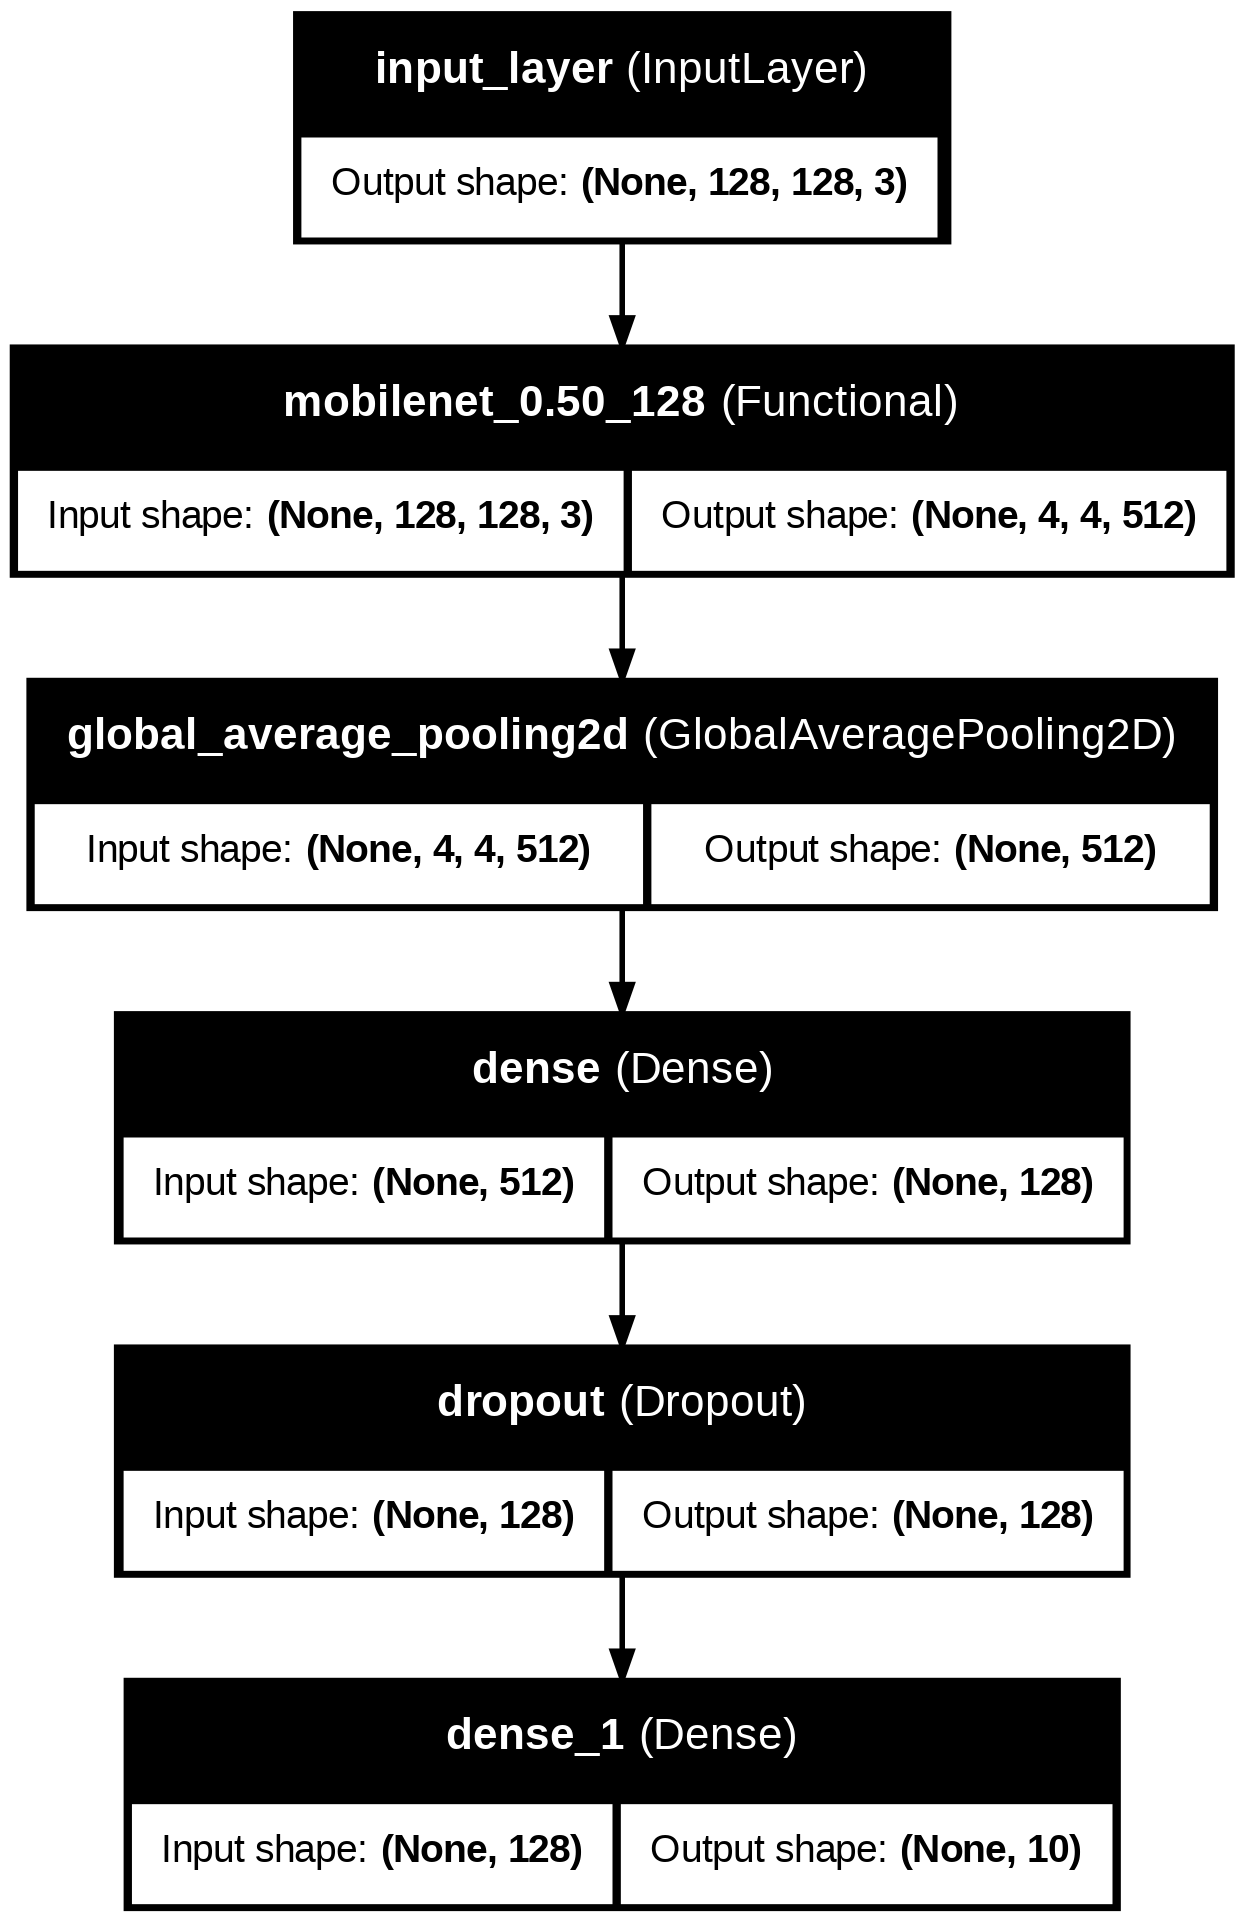

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [6]:
plot_model(
    model,                    
    to_file='model_architecture.png', 
    show_shapes=True,         
    show_layer_names=True,     
    dpi=96                      
)

print("✅ Model architecture saved as 'model_architecture.png'")

✅ Model architecture saved as 'model_architecture.png'


# **Compile Model**

In [3]:
model = tf.keras.models.load_model('/kaggle/input/final-mobilnet128-h5/tensorflow2/default/1/final_MobilNet128.h5')

I0000 00:00:1767381451.185133      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767381451.189047      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **Train Model**

In [5]:
# IMG_SIZE = 128
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1767381499.652080     139 service.cc:152] XLA service 0x7bb394067110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767381499.652117     139 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767381499.652120     139 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767381500.491155     139 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767381510.034794     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


561/561 ━━━━━━━━━━━━━━━━━━━━ 343s 587ms/step - accuracy: 0.8669 - loss: 0.4037 - val_accuracy: 0.9069 - val_loss: 0.2814
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 265ms/step - accuracy: 0.8698 - loss: 0.3845 - val_accuracy: 0.9107 - val_loss: 0.2706
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 264ms/step - accuracy: 0.8701 - loss: 0.3737 - val_accuracy: 0.9197 - val_loss: 0.2508
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 263ms/step - accuracy: 0.8727 - loss: 0.3856 - val_accuracy: 0.9107 - val_loss: 0.2768
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 266ms/step - accuracy: 0.8738 - loss: 0.3684 - val_accuracy: 0.9201 - val_loss: 0.2370
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 152s 270ms/step - accuracy: 0.8789 - loss: 0.3611 - val_accuracy: 0.9264 - val_loss: 0.2403
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 265ms/step - accuracy: 0.8814 - loss: 0.3583 - val_accuracy: 0.9223 - val_loss: 0.2417
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 150s 268ms/step - accuracy: 0.8855 - loss: 0.33

In [8]:
# IMG_SIZE = 128
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 151s 270ms/step - accuracy: 0.8911 - loss: 0.3194 - val_accuracy: 0.9355 - val_loss: 0.2063
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 265ms/step - accuracy: 0.8960 - loss: 0.3055 - val_accuracy: 0.9366 - val_loss: 0.1979
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 263ms/step - accuracy: 0.8919 - loss: 0.3188 - val_accuracy: 0.9255 - val_loss: 0.2180
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 147s 263ms/step - accuracy: 0.8931 - loss: 0.3159 - val_accuracy: 0.9270 - val_loss: 0.2239
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 266ms/step - accuracy: 0.8948 - loss: 0.3102 - val_accuracy: 0.9360 - val_loss: 0.2015
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 152s 271ms/step - accuracy: 0.8952 - loss: 0.3160 - val_accuracy: 0.9424 - val_loss: 0.1829
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 150s 267ms/step - accuracy: 0.8932 - loss: 0.3187 - val_accuracy: 0.9328 - val_loss: 0.1911
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 263ms/step - accuracy: 0.8925 -

In [38]:
# IMG_SIZE = 96
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 132s 215ms/step - accuracy: 0.3147 - loss: 1.9152 - val_accuracy: 0.6019 - val_loss: 1.1728
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 86s 153ms/step - accuracy: 0.5718 - loss: 1.2324 - val_accuracy: 0.6731 - val_loss: 0.9539
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 91s 163ms/step - accuracy: 0.6365 - loss: 1.0397 - val_accuracy: 0.7422 - val_loss: 0.8083
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 92s 164ms/step - accuracy: 0.6611 - loss: 0.9742 - val_accuracy: 0.7447 - val_loss: 0.7698
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 88s 157ms/step - accuracy: 0.6843 - loss: 0.8962 - val_accuracy: 0.7523 - val_loss: 0.7461
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 95s 169ms/step - accuracy: 0.7100 - loss: 0.8488 - val_accuracy: 0.7788 - val_loss: 0.6713
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 91s 162ms/step - accuracy: 0.7147 - loss: 0.8269 - val_accuracy: 0.8043 - val_loss: 0.6101
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 86s 154ms/step - accuracy: 0.7265 - loss: 

# **Test / Inference**

In [ ]:
test_dir = '../input/state-farm-distracted-driver-detection/imgs/test'
import glob

for img_path in glob.glob(f"{test_dir}/*.jpg"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=(0,-1))  # shape = (1,128,128,1)
    
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    print(f"{img_path} -> Class: {class_idx}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
../input/state-farm-distracted-driver-detection/imgs/test/img_96590.jpg -> Class: 8, Confidence: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_32366.jpg -> Class: 5, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_99675.jpg -> Class: 6, Confidence: 0.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_85937.jpg -> Class: 5, Confidence: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_73903.jpg -> Class: 7, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_89410.jpg -> Class: 5, Confidence: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
../input/state-farm-distracted-driver-detection/imgs/test/img_70462.jpg -> Class: 4, Confidence: 0.74
1/1 ━━━━━━━━━━━━━━━━━━

# **Save Model + Convert to TFLite INT8**

In [33]:
model.save("driver_monitor_modelv96.h5")  

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("driver_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved successfully!")


INFO:tensorflow:Assets written to: /tmp/tmpyztg_8by/assets


INFO:tensorflow:Assets written to: /tmp/tmpyztg_8by/assets


Saved artifact at '/tmp/tmpyztg_8by'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_829')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140142206118096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343239120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343241808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343242192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343242000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343242384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343243920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343244112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343242960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140141343240848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14014134324

W0000 00:00:1767182872.274660      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767182872.274700      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [9]:
model.save("final_MobilNet128v3.h5")

In [10]:
import tensorflow as tf
import numpy as np


# model = tf.keras.models.load_model('final_MobilNet128.h5')


def representative_data_gen():
    
    
    count = 0
    for imgs, labels in val_generator:
        for i in range(imgs.shape[0]):
           
            data = np.expand_dims(imgs[i], axis=0).astype(np.float32)
            yield [data]
            count += 1
            if count >= 200: 
                return


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


converter.inference_input_type = tf.uint8 
converter.inference_output_type = tf.uint8


try:
    tflite_model_quant = converter.convert()
    with open('mobilenet128_aint8v3.tflite', 'wb') as f:
        f.write(tflite_model_quant)
    print("Converted to tflite")
except Exception as e:
    print(f"Error during conversion: {e}")

INFO:tensorflow:Assets written to: /tmp/tmpgld6f8w_/assets


INFO:tensorflow:Assets written to: /tmp/tmpgld6f8w_/assets


Saved artifact at '/tmp/tmpgld6f8w_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136016341147216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290678416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290680912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290680528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290677840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290681104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290679568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290681488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290679760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136014290680336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13601429067937

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1767386600.420232      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767386600.420262      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Converted to tflite


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8
